In [1]:

import numpy as np
import datetime
import glob
import os
import matplotlib.pyplot as plt
import cartopy
from matplotlib import gridspec
import itertools
import cartopy.crs as ccrs
import tqdm
import netCDF4 as nc 
from scipy.stats import linregress
from pyproj import Proj, Transformer
from scipy.interpolate import griddata

import warnings
import pickle
warnings.filterwarnings("ignore")


In [2]:
def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    # m.shadedrelief(scale=scale)
    m.drawlsmask(land_color='gray',ocean_color='white',lakes=True)
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

def mask_observations(observations, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(observations)):
        for j in range(len(observations[0])):
            if np.isnan(observations[i][j]):
                new_inversion[i][j] = np.nan
    return new_inversion


def mask_high_error(stddev, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(stddev)):
        for j in range(len(stddev[0])):
            if stddev[i][j] >= inversion[i][j]*(30/100):
                new_inversion[i][j] = np.nan
    return new_inversion

def mask_sie(sie_map, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(sie_map)):
        for j in range(len(sie_map[0])):
            if not np.isnan(sie_map[i][j]) and sie_map[i][j] < 0.7:
                new_inversion[i][j] = np.nan
    return new_inversion


def pearson(inverse, OIB):
    # pearson coefficient
    ydata = np.array(inverse)
    yfit = np.array(OIB)

    ydata_mean = np.mean(ydata)
    yfit_mean = np.mean(yfit)

    data_diff = ydata - ydata_mean
    fit_diff = yfit - yfit_mean

    top = np.sum( (data_diff) * (fit_diff) )

    bottom = np.sqrt( np.sum(data_diff**2) * np.sum(fit_diff**2) )

    r = top/bottom

    return r

def analyse (calculated_data, validation_data):
    error = np.array(calculated_data) - np.array(validation_data)
    md = np.mean(error)
    rmse = np.sqrt( np.mean( (error)**2 ))
    residuals = error**2
    denom = (calculated_data - np.mean(calculated_data)) ** 2
    r2 = 1 - (np.sum(residuals) / np.sum(denom))

    # Calculate slope and y-intercept
    slope, intercept = np.polyfit(validation_data, calculated_data, 1)

    return md, rmse, r2, slope, intercept


In [2]:
# Load inverse SIT CS_IS_2p_LARM

inverseCSIS20182019 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201811/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201812/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201901/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201902/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201903/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                    '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy']

inverseCSIS20192020 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201911/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201912/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202001/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202002/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202003/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202004/15tesselationDelaunay_initcell800_iteration3000000_date_window5j_error0.01_ice.npy']

inverseCSIS20202021 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202011/15tesselationDelaunay_initcell800_iteration2000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202012/15tesselationDelaunay_initcell800_iteration2000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202101/15tesselationDelaunay_initcell800_iteration2000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202102/15tesselationDelaunay_initcell800_iteration2000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202103/15tesselationDelaunay_initcell800_iteration2000000_date_window5j_error0.01_ice.npy',
                   '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202104/15tesselationDelaunay_initcell800_iteration2000000_date_window5j_error0.01_ice.npy']

inverse_CSIS = [inverseCSIS20182019, inverseCSIS20192020, inverseCSIS20202021]


inverseCSAK20182019 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201811/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201812/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201901/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201902/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201903/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201904/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy']

inverseCSAK20192020 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201911/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/201912/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202001/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202002/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202003/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202004/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy']

inverseCSAK20202021 = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202011/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202012/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202101/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202102/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202103/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy',
                       '/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/results_npy/non_interpolated_input/202104/15tesselationDelaunay_initcell600_iteration1000000_window5j_error0.01_ice.npy']

inverse_CSAK = [inverseCSAK20182019, inverseCSAK20192020, inverseCSAK20202021]

In [3]:
# Données masqués pour comparer CS_IS et CS_AK
inverse_sit_CSIS_mask = []

for i in range(len(inverse_CSIS)):
    for j in range(len(inverseCSIS20182019)):
        ak = np.load(inverse_CSAK[i][j])
        csis = np.load(inverse_CSIS[i][j])

        csis = mask_observations(ak, csis)

        inverse_sit_CSIS_mask.append(np.nanmean(csis))

NameError: name 'mask_observations' is not defined

In [ ]:
# Données Awismos

awismos_20182019 = ['/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2018/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201811-fv2p4.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2018/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201812-fv2p4.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201901-fv2p4.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201902-fv2p4.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201903-fv2p4.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201904-fv2p4.nc']

awismos_20192020 = ['/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201911-fv2p4.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2019/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-201912-fv2p4.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2020/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202001-fv2p4.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2020/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202002-fv2p4.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2020/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202003-fv2p4.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2020/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202004-fv2p4.nc']

awismos_20202021 = ['/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2020/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202011-fv2p4.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2020/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202012-fv2p4.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2021/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202101-fv2p4.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2021/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202102-fv2p4.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2021/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202103-fv2p4.nc',
                    '/home/erb/masterproject/MSCI_project/validation_data/awismos/data_awismos_l3c_month/2021/awi-siral-l3c-sithick-cryosat2-rep-nh_25km_ease2-202104-fv2p4.nc']

awismos= [awismos_20182019, awismos_20192020, awismos_20202021]

awismos_sit = []

for i in range(len(awismos)):
    for j in range(len(awismos_20182019)):
        sit = nc.Dataset(awismos[i][j]).variables['sea_ice_thickness'][0][36:396,36:396][::-1, :]

        awismos_sit.append(np.nanmean(sit))
    


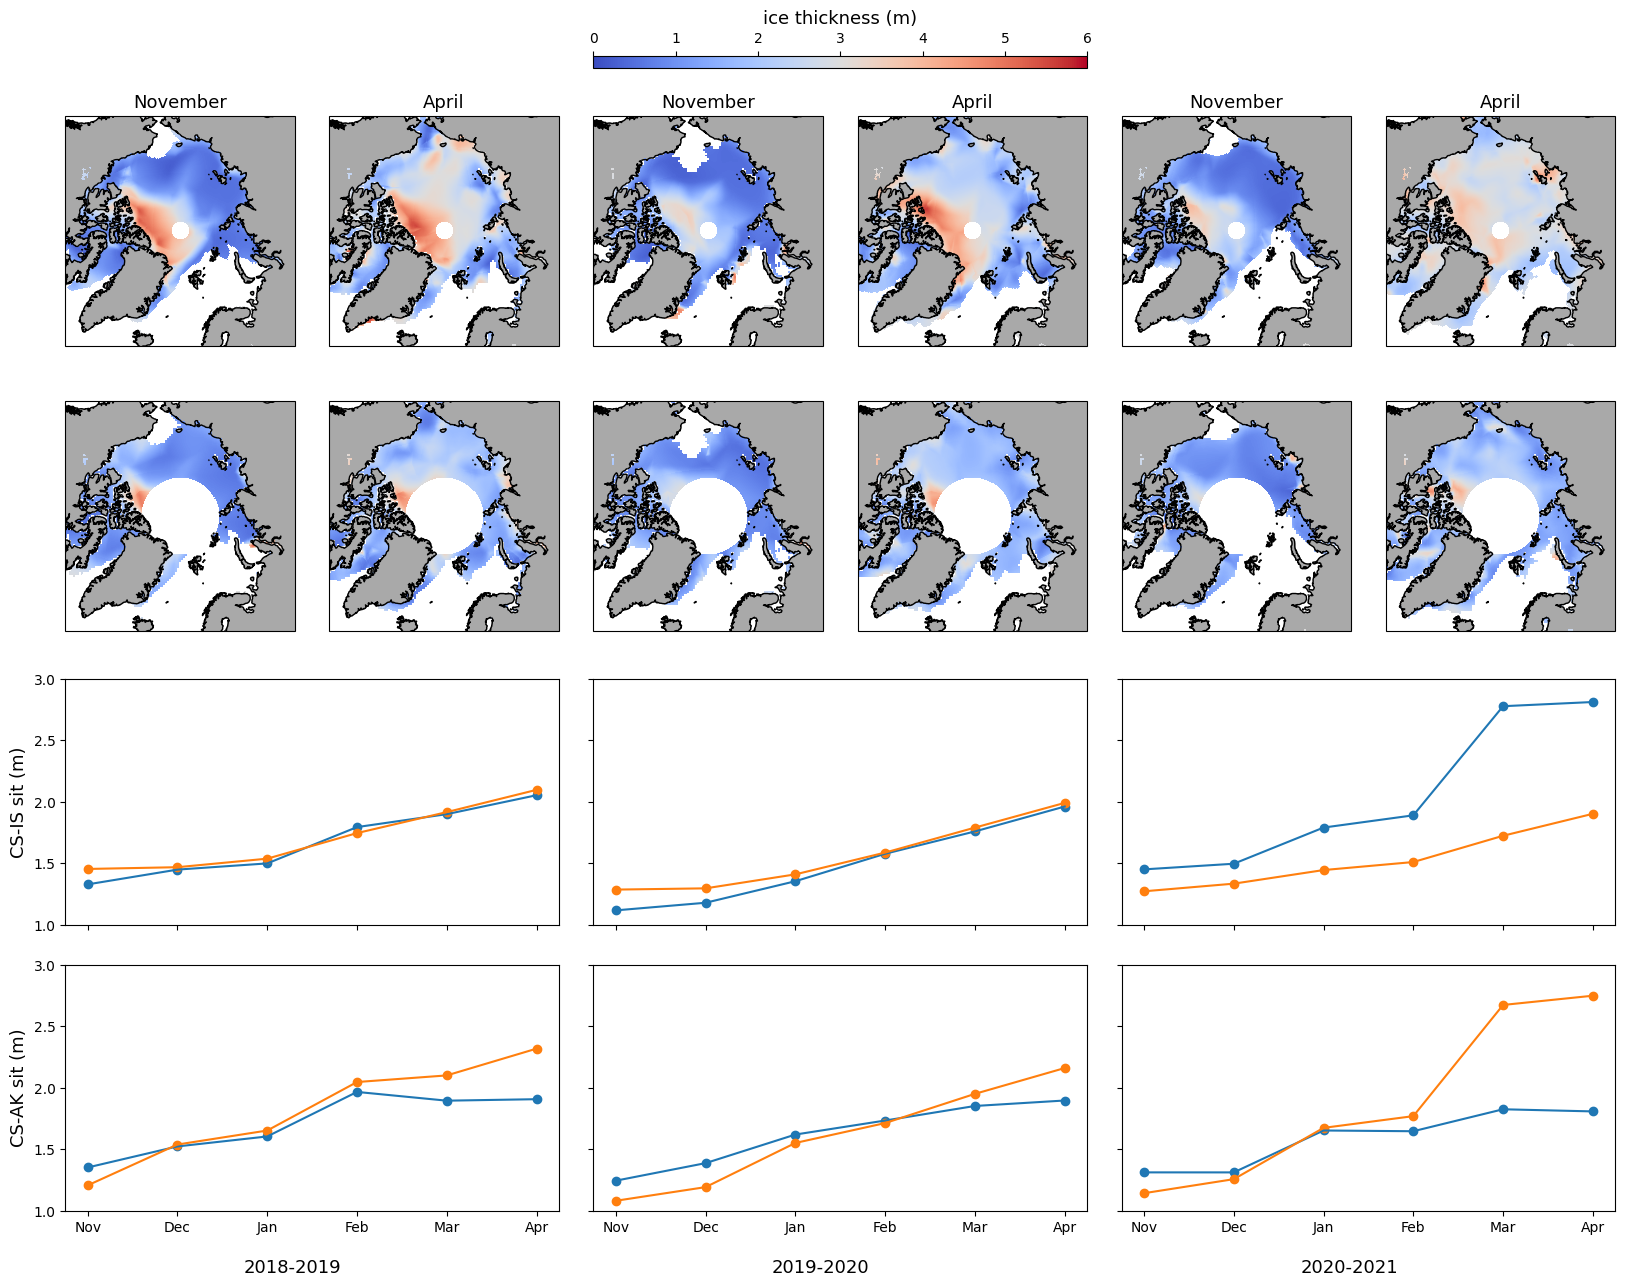

In [ ]:
fig = plt.figure(figsize=(20,15))
spec = gridspec.GridSpec(ncols=6, nrows=5, hspace=0.2, wspace=0.15, height_ratios=[0.05,1,1, 1, 1])


months = ["November", "April", "November", "April", "November", "April"]
date = ['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr']
lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")


inverse_map_CSIS = [np.load(inverseCSIS20182019[0]), np.load(inverseCSIS20182019[5]), np.load(inverseCSIS20192020[0]), 
                    np.load(inverseCSIS20192020[5]), np.load(inverseCSIS20202021[0]), np.load(inverseCSIS20202021[5])]


inverse_map_CSAK = [np.load(inverseCSAK20182019[0]), np.load(inverseCSAK20182019[5]), np.load(inverseCSAK20192020[0]), 
                    np.load(inverseCSAK20192020[5]), np.load(inverseCSAK20202021[0]), np.load(inverseCSAK20202021[5])]


for count, month in enumerate(months):
    ax = fig.add_subplot(spec[count + 6],projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax.coastlines()  
    ax.set_title(month, fontsize=13) 
    p_map = ax.pcolormesh(lon_g,lat_g,inverse_map_CSIS[count],cmap='coolwarm',vmin=0,vmax=6,
                          transform=ccrs.PlateCarree())  

for count in range(0, 6):
    ax = fig.add_subplot(spec[count + 12],projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax.coastlines()  
    #ax.set_title(month, fontsize=13) 
    p_map = ax.pcolormesh(lon_g,lat_g,inverse_map_CSAK[count],cmap='coolwarm',vmin=0,vmax=6,
                          transform=ccrs.PlateCarree())  


cax = fig.add_subplot(spec[2:4])
fig.colorbar(p_map, cax =cax, orientation = "horizontal",fraction=.1)
cax.set_title('ice thickness (m)', fontsize = 13)
cax.xaxis.set_ticks_position('top')
#cax.xaxis.set_label_position('top')

ax = fig.add_subplot(spec[18:20])
ax.scatter(date, inverse_sit_CSIS[:6], cmap = 'green')
ax.plot(date, inverse_sit_CSIS[:6])
ax.scatter(date, awismos_sit[:6])
ax.plot(date, awismos_sit[:6])
#ax.grid(which = 'both')
ax.set_ylabel('CS-IS sit (m)', fontsize = 13)
ax.xaxis.set_ticklabels([])
ax.set_yticks([1,1.5,2,2.5,3])
ax.set_ylim(1, 3)
ax = fig.add_subplot(spec[20:22])
ax.scatter(date, inverse_sit_CSIS[6:12])
ax.plot(date, inverse_sit_CSIS[6:12])
ax.scatter(date, awismos_sit[6:12])
ax.plot(date, awismos_sit[6:12])
ax.yaxis.set_ticklabels([])
ax.xaxis.set_ticklabels([])
#ax.grid(which = 'both')
ax.set_ylim(1, 3)
ax.set_yticks([1,1.5,2,2.5,3])
ax = fig.add_subplot(spec[22:24])
ax.scatter(date, inverse_sit_CSIS[12:18])
ax.plot(date, inverse_sit_CSIS[12:18])
ax.scatter(date, awismos_sit[12:18])
ax.plot(date, awismos_sit[12:18])
ax.yaxis.set_ticklabels([])
ax.xaxis.set_ticklabels([])
#ax.grid(which = 'both')
ax.set_ylim(1, 3)
ax.set_yticks([1,1.5,2,2.5,3])


ax = fig.add_subplot(spec[24:26])
ax.scatter(date, inverse_sit_CSAK[:6])
ax.plot(date, inverse_sit_CSAK[:6])
ax.scatter(date, inverse_sit_CSIS_mask[:6])
ax.plot(date, inverse_sit_CSIS_mask[:6])
#ax.scatter(date, awismos_sit[:6])
#ax.plot(date, awismos_sit[:6])
ax.set_ylabel('CS-AK sit (m)', fontsize = 13)
ax.set_ylim(1, 3)
ax.text(1.74, 0.5,'2018-2019', fontsize = 13)
ax.set_yticks([1,1.5,2,2.5,3])
ax = fig.add_subplot(spec[26:28])
ax.scatter(date, inverse_sit_CSAK[6:12])
ax.plot(date, inverse_sit_CSAK[6:12])
ax.scatter(date, inverse_sit_CSIS_mask[6:12])
ax.plot(date, inverse_sit_CSIS_mask[6:12])
#ax.scatter(date, awismos_sit[6:12])
#ax.plot(date, awismos_sit[6:12])
ax.yaxis.set_ticklabels([])
ax.set_ylim(1, 3)
ax.text(1.74, 0.5,'2019-2020', fontsize = 13)
ax.set_yticks([1,1.5,2,2.5,3])
ax = fig.add_subplot(spec[28:30])
ax.scatter(date, inverse_sit_CSAK[12:18])
ax.plot(date, inverse_sit_CSAK[12:18])
ax.scatter(date, inverse_sit_CSIS_mask[12:18])
ax.plot(date, inverse_sit_CSIS_mask[12:18])
#ax.scatter(date, awismos_sit[12:18])
#ax.plot(date, awismos_sit[12:18])
ax.yaxis.set_ticklabels([])
ax.set_ylim(1, 3)
ax.text(1.74, 0.5,'2020-2021', fontsize = 13)
ax.set_yticks([1,1.5,2,2.5,3])




In [ ]:
## Figure d'erreurs

AKCPOM_20182019 = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/error_map/2018-2019/AKCPOM_Period_15j.npy')
AKCPOM_20192020 = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/error_map/2019-2020/AKCPOM_Period_15j.npy')
AKCPOM_20202021 = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/error_map/2020-2021/AKCPOM_Period_15j.npy')

CS2CPOM_20182019 = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/error_map/2018-2019/CS2CPOM_Period_15j.npy')
CS2CPOM_20192020 = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/error_map/2019-2020/CS2CPOM_Period_15j.npy')
CS2CPOM_20202021 = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/error_map/2020-2021/CS2CPOM_Period_15j.npy')

AKLARM_20182019 = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/error_map/2018-2019/AK_Period_15j.npy')
AKLARM_20192020 = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/error_map/2019-2020/AK_Period_15j.npy')
AKLARM_20202021 = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_AK_2p_LARM/error_map/2020-2021/AK_Period_15j.npy')

CS2LARM_20182019 = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/error_map/2018-2019/CS2_Period_15j.npy')
CS2LARM_20192020 = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/error_map/2019-2020/CS2_Period_15j.npy')
CS2LARM_20202021 = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/error_map/2020-2021/CS2_Period_15j.npy')

IS2_20182019 = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/error_map/2018-2019/IS2_Period_15j.npy')
IS2_20192020 = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/error_map/2019-2020/IS2_Period_15j.npy')
IS2_20192021 = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/error_map/2020-2021/IS2_Period_15j.npy')


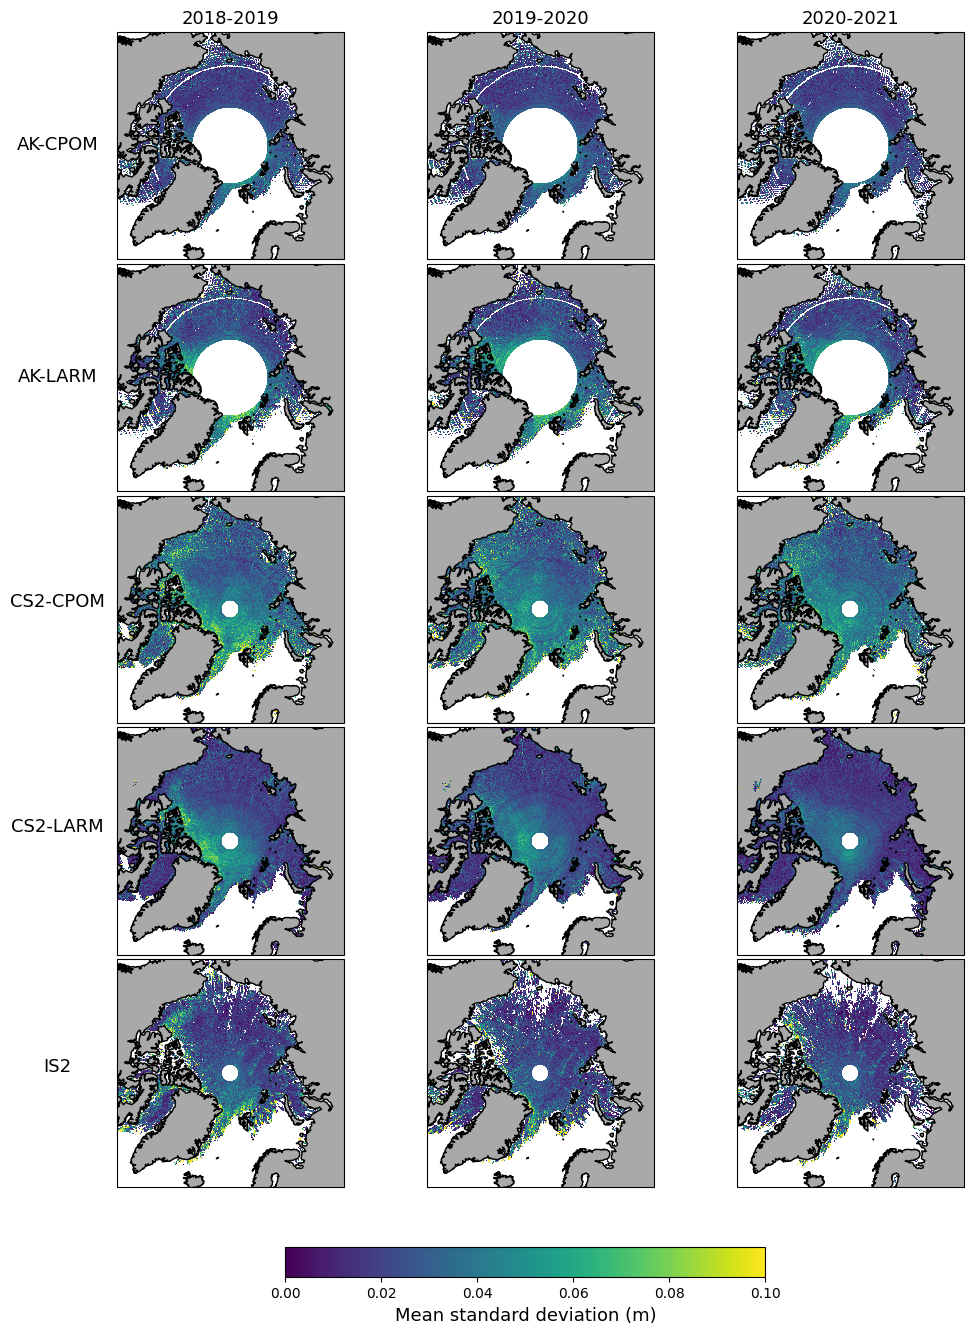

In [ ]:
fig = plt.figure(figsize=(12,15))
spec = gridspec.GridSpec(ncols=3, nrows=5, hspace=0.02, wspace=0.0015)

lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")


AK = [AKCPOM_20182019, AKCPOM_20192020, AKCPOM_20202021, AKLARM_20182019, AKLARM_20192020, AKLARM_20202021]
CS2 = [CS2CPOM_20182019, CS2CPOM_20192020, CS2CPOM_20202021, CS2LARM_20182019, CS2LARM_20192020, CS2LARM_20202021]
IS2 = [IS2_20182019, IS2_20192020, IS2_20192021]
years = ['2018-2019', '2019-2020','2020-2021']
data_type = ["AK-CPOM", "AK-LARM", "CS2-CPOM", "CS2-LARM", "IS2"]

for count in range(6):
    ax = fig.add_subplot(spec[count],projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax.coastlines()  
    p_map = ax.pcolormesh(lon_g,lat_g,AK[count],cmap='viridis',vmin = 0, vmax = 0.25,
                          transform=ccrs.PlateCarree()) 
    if count < 3:
        ax.set_title(years[count], fontsize = 13)


for count in range(0, 6):
    ax = fig.add_subplot(spec[count + 6],projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax.coastlines()  
    p_map = ax.pcolormesh(lon_g,lat_g,CS2[count],cmap='viridis',vmin = 0, vmax = 0.1,
                          transform=ccrs.PlateCarree())  

for count in range(3): 
    ax = fig.add_subplot(spec[count + 12],projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax.coastlines()  
    p_map = ax.pcolormesh(lon_g,lat_g,IS2[count],cmap='viridis',vmin = 0, vmax = 0.1,
                          transform=ccrs.PlateCarree())  



cbar_ax = fig.add_axes([0.3, 0.05, 0.4, 0.02])
cbar = fig.colorbar(p_map, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Mean standard deviation (m)', fontsize = 13)  




fig.text(0.11, 0.805, data_type[0], va='center', ha='center', fontsize=13)
fig.text(0.11, 0.6505, data_type[1], va='center', ha='center', fontsize=13)
fig.text(0.11, 0.5, data_type[2], va='center', ha='center', fontsize=13)
fig.text(0.11, 0.35, data_type[3], va='center', ha='center', fontsize=13)
fig.text(0.11, 0.19, data_type[4], va='center', ha='center', fontsize=13)

save_fig = 0

if save_fig == 1 : 
    plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation/maps_error.png', dpi = 300)


In [ ]:
## Figure pour comparer les inversions en fonction de la densité de glace utilisée

inversion_MYI = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201811/08tesselationDelaunay_initcell1500_iteration1500000_date_window15j_errorinput_alphacs20.75_hierarchicalno_ice.npy')
inversion_FYI = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201811/08tesselationDelaunay_initcell1500_iteration1500000_date_window15j_errorinput_alphacs20.75_hierarchicalno_ice.npy')
inversion_Mixte = np.load('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201811/15tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_ice.npy')

inversion = [inversion_FYI, inversion_Mixte, inversion_MYI]

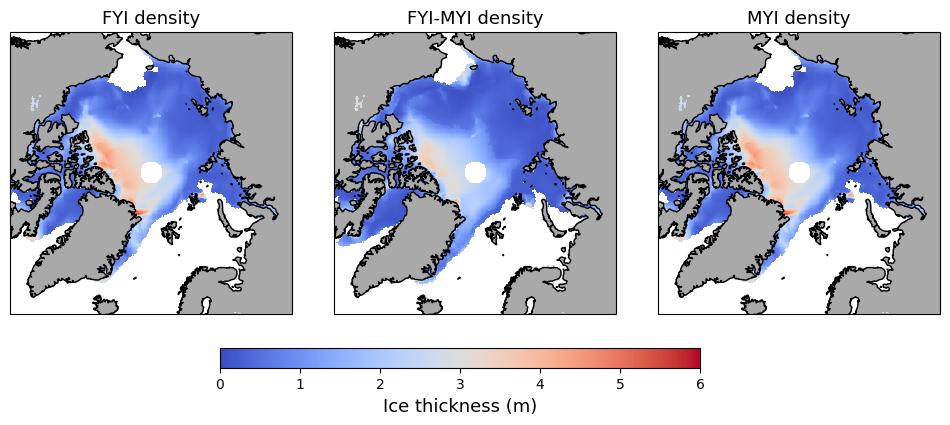

In [ ]:
fig = plt.figure(figsize=(12,10))
spec = gridspec.GridSpec(ncols=3, nrows=1, hspace=0.02, wspace=0.15)

lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")

ice_density = ['FYI density', 'FYI-MYI density', 'MYI density']

for i, density_type in enumerate(ice_density):
    ax = fig.add_subplot(spec[i],projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax.coastlines()  
    p_map = ax.pcolormesh(lon_g,lat_g,inversion[i],cmap='coolwarm',vmin = 0, vmax = 6,
                          transform=ccrs.PlateCarree()) 
    ax.set_title(ice_density[i], fontsize = 13)
    

    
cbar_ax = fig.add_axes([0.3, 0.3, 0.4, 0.02])
cbar = fig.colorbar(p_map, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Ice thickness (m)', fontsize = 13)  




In [4]:
def lonlat_to_xy(coords_1, coords_2, hemisphere, inverse=False):

    """Converts between longitude/latitude and EASE xy coordinates.
 
    Args:
        lon (float): WGS84 longitude
        lat (float): WGS84 latitude
        hemisphere (string): 'n' or 's'
        inverse (bool): if true, converts xy to lon/lat
 
    Returns:
        tuple: pair of xy or lon/lat values
    """

    EASE_Proj = {'n': 'EPSG:3408',
                 's': 'EPGS:3409'}
    
    WGS_Proj = 'EPSG:4326'
    
    #for coords in [coords_1, coords_2]: assert isinstance(coords,(np.ndarray,list))

    if inverse == False: # lonlat to xy
        
        lon, lat = coords_1, coords_2
        
        transformer = Transformer.from_crs(WGS_Proj, EASE_Proj[hemisphere])
        
        x, y = transformer.transform(lat, lon)
        
        return (x, y)

    else: # xy to lonlat
        
        x, y = coords_1, coords_2
        
        transformer = Transformer.from_crs(EASE_Proj[hemisphere], WGS_Proj)
        
        lat, lon = transformer.transform(x, y)
        
        return (lon, lat)

In [39]:
test = nc.Dataset('/home/erb/masterproject/MSCI_project/validation_data/mpr_retrieval_amsr_20181115_ease_25_v0.2.nc')
sd = test.variables['snd']
lon = test.variables['lon'][:,:]
lat = test.variables['lat'][:,:]

In [90]:
lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")

IS2 = np.load("/home/erb/masterproject/MSCI_project/snow_ice/carmen/daily_numpys/IS2/FB_interp_2019_25km_20190115.npy")


inverse_delaunay_snow_files = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201811/15IS2-v6tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_snow.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201911/15IS2-v6tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_snow.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/202011/15IS2-v6tesselationDelaunay_initcell1500_iteration1500000_date_window15j_icedensitymixte_alphacs20.75_hierarchicalno_snow.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190215_window+-2j_error0.01_snow.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190315_window+-2j_error0.01_snow.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/tesselationDelaunay_initcell1000_iteration700000_date20190415_window+-2j_error0.01_snow.npy']

inverse_voronoi_snow_files = ['/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201811/tesselationVoronoi_initcell1000_iteration700000_date_window+-2j_error0.01_snow.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201812/tesselationVoronoi_initcell1000_iteration700000_date_window+-2j_error0.01_snow.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201901/tesselationVoronoi_initcell1000_iteration700000_date_window+-2j_error0.01_snow.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201902/tesselationVoronoi_initcell1000_iteration700000_date_window+-2j_error0.01_snow.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201903/tesselationVoronoi_initcell1000_iteration700000_date_window+-2j_error0.01_snow.npy',
                     '/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/results_npy/non_interpolated_input/201904/tesselationVoronoi_initcell1000_iteration700000_date_window+-2j_error0.01_snow.npy']

amsr2_snow_files = ['/home/erb/masterproject/MSCI_project/validation_data/AMSR2/mpr_retrieval_amsr_20181115_ease_25_v0.2.nc',
                     '/home/erb/masterproject/MSCI_project/validation_data/AMSR2/mpr_retrieval_amsr_20191115_ease_25_v0.2.nc',
                     '/home/erb/masterproject/MSCI_project/validation_data/AMSR2/mpr_retrieval_amsr_20201115_ease_25_v0.2.nc',
                     '/home/cn/Sentinel3Snod/DATA/Bremen_snow/2019/02/snowdepth_amsr2_20190215v1.1.nc',
                     '/home/cn/Sentinel3Snod/DATA/Bremen_snow/2019/03/snowdepth_amsr2_20190315v1.1.nc',
                     '/home/cn/Sentinel3Snod/DATA/Bremen_snow/2019/04/snowdepth_amsr2_20190415v1.1.nc']

    # fpath = '/home/cn/Sentinel3Snod/DATA/Bremen_snow/2019/03/snowdepth_amsr2_20190315v1.1.nc'



import xarray as xr

def get_pm_bremen_snow_lonlats():
    fpath = '/home/erb/masterproject/MSCI_project/validation_data/AMSR2/mpr_retrieval_amsr_20181115_ease_25_v0.2.nc'
    ds = xr.open_dataset(fpath)
    return ds['lon'].values, ds['lat'].values

def get_pm_bremen_snow_values(fpath):
    # fpath = '/home/cn/Sentinel3Snod/DATA/Bremen_snow/2019/03/snowdepth_amsr2_20190315v1.1.nc'
    ds = xr.open_dataset(fpath)
    return ds['snd'].values



lon_AMSR2, lat_AMSR2 = get_pm_bremen_snow_lonlats()
# snow_AMSR2, snow_unc_AMSR2 = get_pm_bremen_snow_values()

x_AMSR2, y_AMSR2 = lonlat_to_xy(lon_AMSR2, lat_AMSR2, "n", inverse=False)

lon_g = np.load("/home/erb/masterproject/MSCI_project/new_lon_25km.npy")
lat_g = np.load("/home/erb/masterproject/MSCI_project/new_lat_25km.npy")

x_EASE2, y_EASE2 = lonlat_to_xy(lon_g, lat_g, "n", inverse=False)


def snow_amsr2(path_awismos):

    snow_AMSR2 = get_pm_bremen_snow_values(path_awismos)
    snow_AMSR2_EASE2 = griddata((x_AMSR2.ravel(), y_AMSR2.ravel()), snow_AMSR2.ravel(), (x_EASE2, y_EASE2), method='nearest')
    #snow_AMSR2_EASE2 = snow_AMSR2_EASE2/100.
    snow_AMSR2_EASE2 = snow_AMSR2_EASE2
    return snow_AMSR2_EASE2

def inverse_snow(inverse_snow_files, path_awismos):
    snow_inverse, ST_amsr2 = [], []

    snow_AMSR2 = get_pm_bremen_snow_values(path_awismos)
    snow_AMSR2_EASE2 = griddata((x_AMSR2.ravel(), y_AMSR2.ravel()), snow_AMSR2.ravel(), (x_EASE2, y_EASE2), method='nearest')
    #snow_AMSR2_EASE2 = snow_AMSR2_EASE2/100.
    snow_AMSR2_EASE2 = snow_AMSR2_EASE2
    
    snow_inverse_data = np.load(inverse_snow_files)

    for k in range(360):
        for j in range(360):
        #if not SIT_awismos.mask[k][j] and not np.isnan(ice_inverse_data[k][j]):
            if not np.isnan(snow_inverse_data[k][j]) and not np.isnan(snow_AMSR2_EASE2[k][j]):
                snow_inverse.append(snow_inverse_data[k][j])
                ST_amsr2.append(snow_AMSR2_EASE2[k][j])
    
    return snow_inverse, ST_amsr2

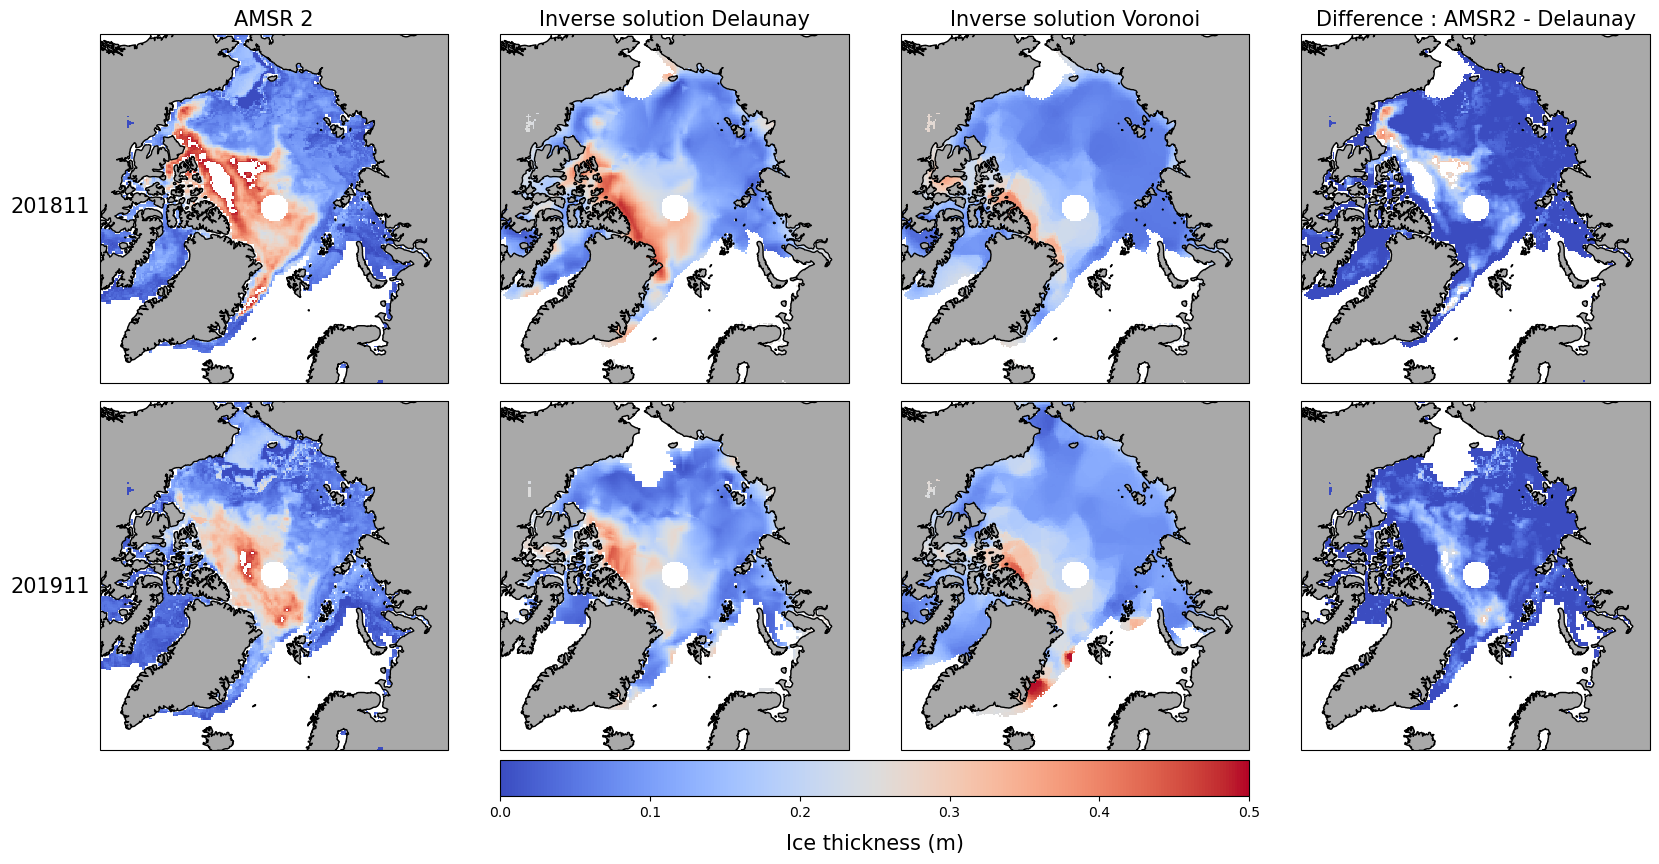

In [127]:
fig = plt.figure(figsize=(20, 10))
spec = gridspec.GridSpec(ncols=4, nrows=3, hspace=0.01, wspace=0.15,height_ratios=[1,1,0.1])



for i in range(2):
    ax = fig.add_subplot(spec[i,0],projection=ccrs.NorthPolarStereo())

    if i == 0: 
        ax.set_title('AMSR 2', fontsize = 15)
    ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax.coastlines()  
    p_map = ax.pcolormesh(lon_g,lat_g, mask_observations(IS2,snow_amsr2(amsr2_snow_files[i])),cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 0.5)


    ax2 = fig.add_subplot(spec[i,1],projection=ccrs.NorthPolarStereo())
    if i == 0:
        ax2.set_title('Inverse solution Delaunay', fontsize = 15)
    ax2.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    ax2.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax2.coastlines()  
    p_map = ax2.pcolormesh(lon_g,lat_g,np.load(inverse_delaunay_snow_files[i]) ,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 0.5)

    ax3 = fig.add_subplot(spec[i,2], projection = ccrs.NorthPolarStereo())
    if i == 0:
        ax3.set_title('Inverse solution Voronoi', fontsize = 15)
    ax3.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    ax3.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax3.coastlines()  
    p_map = ax3.pcolormesh(lon_g,lat_g,np.load(inverse_voronoi_snow_files[i]) ,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 0.5)

    ax3 = fig.add_subplot(spec[i,3], projection = ccrs.NorthPolarStereo())
    if i == 0:
        ax3.set_title('Difference : AMSR2 - Delaunay', fontsize = 15)
    ax3.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    ax3.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax3.coastlines()  
    p_map = ax3.pcolormesh(lon_g,lat_g,mask_observations(IS2,snow_amsr2(amsr2_snow_files[i])) - np.load(inverse_delaunay_snow_files[i]) ,cmap='coolwarm',alpha=1.0, transform=ccrs.PlateCarree(), vmin = 0, vmax = 0.5)


cax = fig.add_subplot(spec[9:11])
fig.colorbar(p_map, cax =cax, orientation = "horizontal")
cax.xaxis.set_ticks_position('bottom')
cax.set_xlabel('Ice thickness (m)', labelpad = 10, fontsize = 15)
cax.xaxis.set_label_position('bottom')

date = ["201811", "201911"]

fig.text(0.1, 0.7, date[0], va='center', ha='center', fontsize=15)
fig.text(0.1, 0.32, date[1], va='center', ha='center', fontsize=15)


# Afficher le graphique
save_fig = 0
if save_fig == 1: 
    # plt.savefig('/home/erb/masterproject/MSCI_project/snow_ice/CS_IS_2p_LARM/validation/comparison_awismos_2018-2019.png')
    plt.savefig('./comparison_amsr2_2018-2019.png')

plt.show()
